In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re  
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
sns.set()

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets 
import torchvision.transforms as tt

In [3]:
df = pd.read_csv('../Downloads/stack-overflow-developer-survey-2021/survey_results_public.csv')

In [4]:
df.sample(1).iloc[0]

ResponseId                                                                  30922
MainBranch                                         I am a developer by profession
Employment                                                     Employed full-time
Country                                                                 Australia
US_State                                                                      NaN
UK_Country                                                                    NaN
EdLevel                              Bachelor’s degree (B.A., B.S., B.Eng., etc.)
Age1stCode                                                           5 - 10 years
LearnCode                       Other online resources (ex: videos, blogs, etc...
YearsCode                                                                      18
YearsCodePro                                                                    6
DevType                         Developer, full-stack;Engineer, data;Developer...
OrgSize         

In [5]:
#here i'm choosing the columns, which is contains (;) to make them as a list 
to_split = df.columns[16:30].tolist()
to_split.append('DevType')

In [6]:
# i do it like that because i want to split my columns values according to (;) , which is will not
# work because the Nan Values
df = df.fillna("missing")

In [7]:
# check if it will work
df[to_split[0]].apply(lambda x : x.split(';')).sample(1).iloc[0]

['C++', 'Go', 'Java', 'Python']

In [8]:
for i in to_split:
    df[i] = df[i].apply(lambda x: x.split(';'))

In [9]:
df.sample(1).iloc[0]

ResponseId                                                                  55226
MainBranch                                         I am a developer by profession
Employment                                                     Employed full-time
Country                                                  United States of America
US_State                                                            Massachusetts
UK_Country                                                                missing
EdLevel                              Bachelor’s degree (B.A., B.S., B.Eng., etc.)
Age1stCode                                                          11 - 17 years
LearnCode                       School;Friend or family member;Books / Physica...
YearsCode                                                                      15
YearsCodePro                                                                    3
DevType                                                     [Developer, back-end]
OrgSize         

### I Think it worked will 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83439 entries, 0 to 83438
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ResponseId                    83439 non-null  int64 
 1   MainBranch                    83439 non-null  object
 2   Employment                    83439 non-null  object
 3   Country                       83439 non-null  object
 4   US_State                      83439 non-null  object
 5   UK_Country                    83439 non-null  object
 6   EdLevel                       83439 non-null  object
 7   Age1stCode                    83439 non-null  object
 8   LearnCode                     83439 non-null  object
 9   YearsCode                     83439 non-null  object
 10  YearsCodePro                  83439 non-null  object
 11  DevType                       83439 non-null  object
 12  OrgSize                       83439 non-null  object
 13  Currency        

In [11]:
#u will notice that there is something wrong in columns (YearsCode,YearsCodePro)
#because it can not be Object so, we need to handle it
#-------------------------------------------------------------
#here that is the hard way to check what's wrong in your data but why i did it ? 
#if i have many of unique values and i used (column).unique may be i can not see what's wrong 
#so i decide to generalize my problem so, i used regex to solve it 
#if u want to use the easy way, u can use df[specific_column].unique() and look for what is happen
check_columns = ['YearsCode','YearsCodePro']
print(df[~df[check_columns[0]].str.contains('^(\d+|missing)$')]['YearsCode'].unique())
print(df[~df[check_columns[1]].str.contains('^(\d+|missing)$')]['YearsCodePro'].unique())

['Less than 1 year' 'More than 50 years']
['Less than 1 year' 'More than 50 years']


In [12]:
#there is no reason for using 51 instead of 52....etc it just make sense to me 
map_values = {
    'Less than 1 year':'0',
    'More than 50 years':'51'
}

In [13]:
for i in check_columns:
    df[i] = df[i].apply(lambda x : x if x not in map_values.keys() else map_values[x])


In [14]:
for i in check_columns:
    print(df[i].unique())

['missing' '7' '17' '3' '4' '6' '16' '12' '15' '10' '40' '9' '26' '14'
 '39' '20' '8' '19' '5' '0' '22' '2' '1' '34' '21' '13' '25' '24' '30'
 '31' '18' '38' '51' '27' '41' '42' '35' '23' '28' '11' '37' '44' '43'
 '36' '33' '45' '29' '50' '46' '32' '47' '49' '48']
['missing' '10' '4' '5' '6' '2' '30' '9' '18' '12' '21' '1' '16' '0' '15'
 '3' '35' '7' '8' '17' '14' '26' '25' '20' '50' '34' '11' '24' '22' '13'
 '31' '23' '39' '41' '27' '28' '19' '33' '51' '37' '29' '32' '43' '40'
 '38' '45' '42' '46' '36' '44' '47' '48' '49']


### seems everything is good

In [15]:
df.sample(1).iloc[0]

ResponseId                                                                  16392
MainBranch                                         I am a developer by profession
Employment                                                     Employed full-time
Country                                                                    France
US_State                                                                  missing
UK_Country                                                                missing
EdLevel                           Master’s degree (M.A., M.S., M.Eng., MBA, etc.)
Age1stCode                                                          11 - 17 years
LearnCode                       Other online resources (ex: videos, blogs, etc...
YearsCode                                                                       8
YearsCodePro                                                                    3
DevType                         [Developer, mobile, Developer, desktop or ente...
OrgSize         

## Part Two: Get Insights From The Data

In [16]:
#here i'm choosing the columns which is i'm intersted to explore it 
choosing_columns = df.columns[df.columns.str.contains('Have')].tolist()
choosing_columns

['LanguageHaveWorkedWith',
 'DatabaseHaveWorkedWith',
 'PlatformHaveWorkedWith',
 'WebframeHaveWorkedWith',
 'MiscTechHaveWorkedWith',
 'ToolsTechHaveWorkedWith',
 'NEWCollabToolsHaveWorkedWith']

In [17]:
new_df = df[choosing_columns+['DevType']] 
new_df

,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WebframeHaveWorkedWith,MiscTechHaveWorkedWith,ToolsTechHaveWorkedWith,NEWCollabToolsHaveWorkedWith,DevType
0,"[C++, HTML/CSS, JavaScript, Objective-C, PHP, ...","[PostgreSQL, SQLite]",[missing],"[Laravel, Symfony]",[missing],[missing],"[PHPStorm, Xcode]","[Developer, mobile]"
1,"[JavaScript, Python]",[PostgreSQL],[missing],"[Angular, Flask, Vue.js]",[Cordova],"[Docker, Git, Yarn]","[Android Studio, IntelliJ, Notepad++, PyCharm]",[missing]
2,"[Assembly, C, Python, R, Rust]",[SQLite],[Heroku],[Flask],"[NumPy, Pandas, TensorFlow, Torch/PyTorch]",[missing],"[IPython/Jupyter, PyCharm, RStudio, Sublime Te...",[missing]
3,"[JavaScript, TypeScript]",[missing],[missing],"[Angular, jQuery]",[missing],[missing],[missing],"[Developer, front-end]"
4,"[Bash/Shell, HTML/CSS, Python, SQL]","[Elasticsearch, PostgreSQL, Redis]",[missing],[Flask],"[Apache Spark, Hadoop, NumPy, Pandas]","[Docker, Git, Kubernetes, Yarn]","[Atom, IPython/Jupyter, Notepad++, PyCharm, Vim]","[Developer, desktop or enterprise applications..."
...,...,...,...,...,...,...,...,...
83434,"[Clojure, Kotlin, SQL]","[Oracle, SQLite]",[AWS],[missing],[missing],"[Docker, Git]","[IntelliJ, Sublime Text, Vim, Visual Studio Code]","[Developer, back-end]"
83435,[missing],"[Firebase, MariaDB, MySQL, PostgreSQL, Redis, ...",[missing],"[Django, jQuery, Laravel, React.js, Ruby on Ra...","[Flutter, Qt]","[Git, Unity 3D, Unreal Engine]","[Android Studio, Eclipse, Emacs, IntelliJ, Net...","[Developer, full-stack]"
83436,"[Groovy, Java, Python]","[DynamoDB, Elasticsearch, MongoDB, PostgreSQL,...","[AWS, Google Cloud Platform]","[FastAPI, Flask]","[Hadoop, Keras, NumPy, Pandas]","[Ansible, Docker, Git, Terraform]","[Android Studio, Eclipse, IntelliJ, IPython/Ju...",[Data scientist or machine learning specialist...
83437,"[Bash/Shell, JavaScript, Node.js, Python]","[Cassandra, Elasticsearch, MongoDB, PostgreSQL...",[Heroku],"[Django, Express, Flask, React.js]","[NumPy, Pandas, TensorFlow, Torch/PyTorch]","[Ansible, Docker, Git, Terraform]","[PyCharm, Sublime Text]","[Developer, back-end]"


### Q1 : What is the Percentage of each major

In [18]:
import itertools
from collections import Counter
majors = itertools.chain(*list(new_df['DevType']))
majors = list(majors)

In [19]:
frequency_of_jobs = Counter(majors)
frequency_of_jobs

Counter({'Developer, mobile': 9800,
         'missing': 16955,
         'Developer, front-end': 18231,
         'Developer, desktop or enterprise applications': 11036,
         'Developer, full-stack': 32891,
         'Engineer, data': 4176,
         'Other (please specify):': 3545,
         'Data scientist or machine learning specialist': 4273,
         'Developer, back-end': 29071,
         'Academic researcher': 2899,
         'Database administrator': 5655,
         'Scientist': 2015,
         'Student': 4187,
         'Developer, QA or test': 3611,
         'Developer, game or graphics': 2112,
         'Developer, embedded applications or devices': 4598,
         'DevOps specialist': 7058,
         'Data or business analyst': 3792,
         'Designer': 4611,
         'Engineering manager': 3810,
         'Engineer, site reliability': 2448,
         'System administrator': 6079,
         'Product manager': 3074,
         'Senior Executive (C-Suite, VP, etc.)': 2103,
         'Educa

In [20]:
jobs_freq  = pd.DataFrame(frequency_of_jobs.items(),columns=['Major','Frequency']).sort_values('Frequency').reset_index(drop=True)
jobs_freq

,Major,Frequency
0,Marketing or sales professional,638
1,Scientist,2015
2,"Senior Executive (C-Suite, VP, etc.)",2103
3,"Developer, game or graphics",2112
4,Educator,2369
5,"Engineer, site reliability",2448
6,Academic researcher,2899
7,Product manager,3074
8,Other (please specify):,3545
9,"Developer, QA or test",3611


### Note: The Whole images u will see later it is an interactive but i have to convert it to 'png' to render it in Github if u need to work with it as an interactive image Just Remove the png in fig.show()

In [21]:
#!pip install -U kaleido

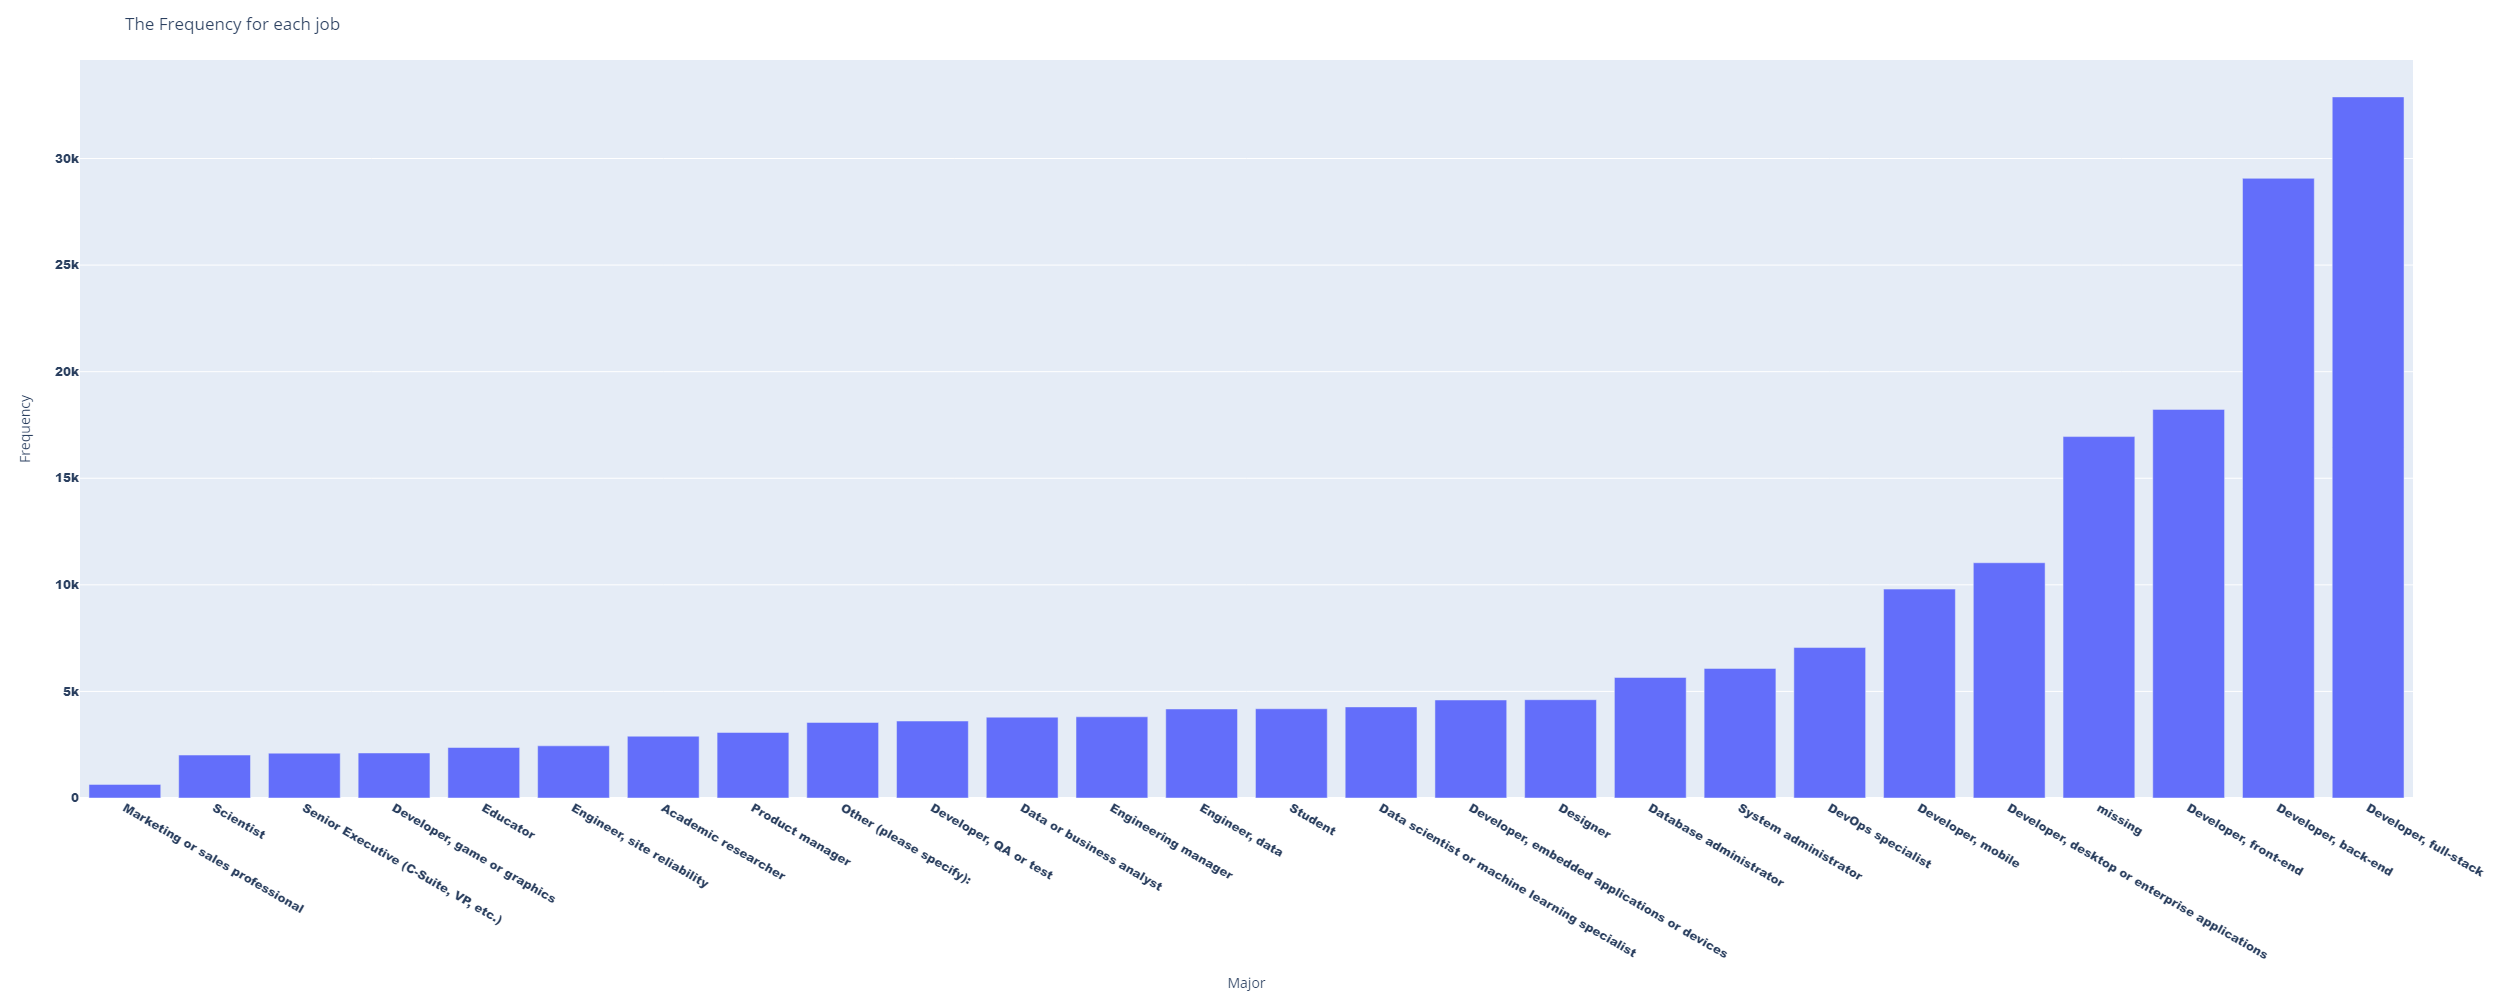

In [138]:
# Here we are Just ploting the Frequencies

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
fig = go.Figure(
    data = px.bar(jobs_freq , x = 'Major' , y= 'Frequency'),
    layout_title_text = "The Frequency for each job"
)
fig.update_xaxes(tickfont_family="Arial Black")
fig.update_yaxes(tickfont_family="Arial Black")
fig.update_layout(width = 2500 , height = 1000)
fig.show("png")
#fig.show()

### Q2 : Get Skill Frequency according to each feature i have

In [23]:
skill_freq = {}
for i in new_df.columns[:-1]:
    hold = list(itertools.chain(*list(new_df[i])))
    hold = Counter(hold)
    skill_freq[i] = hold.items()
skill_freq

{'LanguageHaveWorkedWith': dict_items([('C++', 20057), ('HTML/CSS', 46259), ('JavaScript', 53587), ('Objective-C', 2310), ('PHP', 18130), ('Swift', 4204), ('Python', 39792), ('Assembly', 4632), ('C', 17329), ('R', 4185), ('Rust', 5799), ('TypeScript', 24909), ('Bash/Shell', 22385), ('SQL', 38835), ('C#', 22984), ('Java', 29162), ('Node.js', 27975), ('PowerShell', 8871), ('Ruby', 5569), ('Perl', 2028), ('Matlab', 3846), ('Kotlin', 6866), ('Julia', 1068), ('Haskell', 1749), ('Delphi', 1731), ('Go', 7879), ('Scala', 2148), ('Dart', 4965), ('missing', 1082), ('VBA', 3847), ('Groovy', 2479), ('Clojure', 1552), ('APL', 536), ('LISP', 1096), ('F#', 804), ('Elixir', 1438), ('Erlang', 651), ('Crystal', 466), ('COBOL', 437)]),
 'DatabaseHaveWorkedWith': dict_items([('PostgreSQL', 28424), ('SQLite', 22634), ('missing', 13893), ('Elasticsearch', 9331), ('Redis', 14552), ('MySQL', 35289), ('Microsoft SQL Server', 18896), ('Oracle', 8868), ('MongoDB', 19479), ('MariaDB', 12088), ('DynamoDB', 5137), 

In [24]:
skills_df_freq = pd.DataFrame()
for i in skill_freq.keys():
    hold = pd.DataFrame(list(skill_freq[i]),columns=['Skill','Frequency'])
    hold['Group'] = i
    skills_df_freq = pd.concat([skills_df_freq,hold])
skills_df_freq

,Skill,Frequency,Group
0,C++,20057,LanguageHaveWorkedWith
1,HTML/CSS,46259,LanguageHaveWorkedWith
2,JavaScript,53587,LanguageHaveWorkedWith
3,Objective-C,2310,LanguageHaveWorkedWith
4,PHP,18130,LanguageHaveWorkedWith
...,...,...,...
17,Rider,3255,NEWCollabToolsHaveWorkedWith
18,NetBeans,5839,NEWCollabToolsHaveWorkedWith
19,Webstorm,6564,NEWCollabToolsHaveWorkedWith
20,RubyMine,1219,NEWCollabToolsHaveWorkedWith


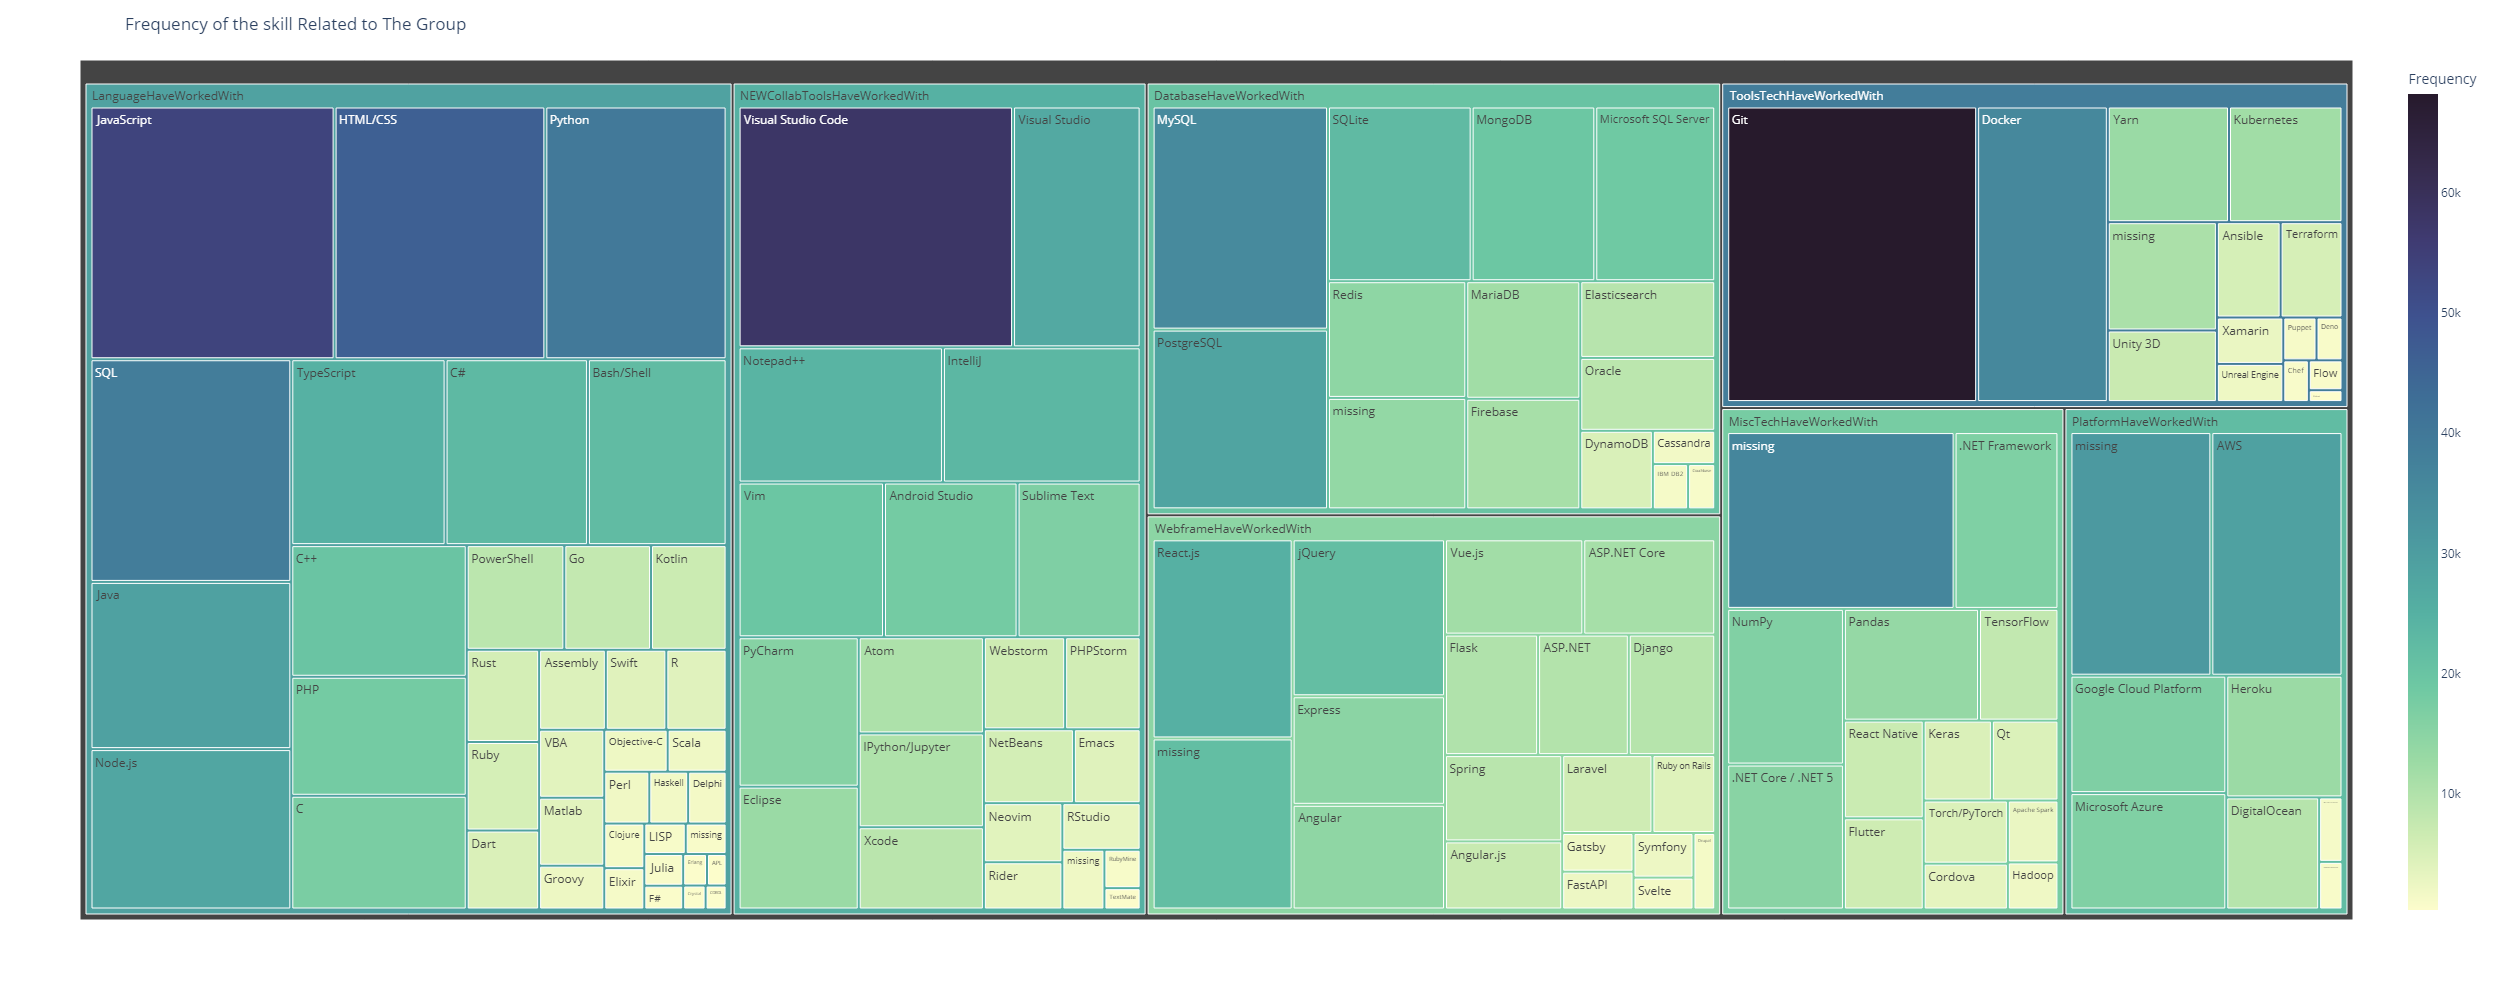

In [136]:
#make a tree map to get sense of your data ,usually it's hard to look to the whole DataFrame
fig = go.Figure(data = px.treemap(skills_df_freq,path = ['Group','Skill'],color_continuous_scale='deep',
          values = 'Frequency',color = 'Frequency') , layout_title_text = "Frequency of the skill Related to The Group")
fig.update_layout(width = 2500 , height = 1000)
fig.show('png')
#fig.show()


### Q3 : Get The Percentage of Each Skill used according to each Major

In [26]:
features = new_df.columns[:-1]
target = list(new_df.DevType)
jobs_skills_freq = {}
for i in jobs_freq['Major'].values:
    jobs_skills_freq[i] = {}
    
for feature in features:
    feature_list = list(new_df[feature])
    
    for ind in range(len(target)):
        feature_row = feature_list[ind]
        target_row = target[ind]
        count_skills = dict(Counter(feature_row))
        
        for job in target_row:
            for skill in count_skills.keys():
                if skill in jobs_skills_freq[job].keys():
                    jobs_skills_freq[job][skill] += count_skills[skill]
                else:
                    jobs_skills_freq[job][skill] = count_skills[skill]


In [27]:
#i kept the print here to show u it is not always everything works smoothy
#i had some trouble and these prints what i did to figure out where is the problem

import copy
jobs_skills_percentage = copy.deepcopy(jobs_skills_freq)
for key in jobs_skills_percentage:
    for skill in jobs_skills_percentage[key].keys():
        #print(jobs_skills_percentage[key][skill],jobs_freq[jobs_freq['Major']==key]['Frequency'])
        #print(key,skill)
        jobs_skills_percentage[key][skill] = jobs_skills_percentage[key][skill] / jobs_freq[jobs_freq['Major']==key].iloc[0]['Frequency']*100
        #print(jobs_skills_percentage[key][skill] , jobs_freq[jobs_freq['Major']==key]['Frequency'][0])
        #print(jobs_skills_percentage[key][skill])
        #print('-------------------------------------------------')


In [28]:
#Put the Data Into DataFrame

job_to_skill_percentage = pd.DataFrame(jobs_skills_percentage).T
job_to_skill_percentage.head()

,HTML/CSS,JavaScript,Node.js,PHP,PowerShell,Python,SQL,Bash/Shell,C#,C,...,Android Studio,Atom,Eclipse,IPython/Jupyter,PHPStorm,Webstorm,RStudio,TextMate,Rider,RubyMine
Marketing or sales professional,71.316614,71.943574,39.341693,42.006270,15.203762,40.909091,57.053292,29.310345,28.369906,21.316614,...,29.467085,19.749216,17.711599,11.285266,12.695925,9.874608,7.680251,5.172414,5.329154,3.918495
Scientist,40.049628,42.431762,20.794045,15.930521,10.521092,76.079404,34.937965,40.942928,17.866005,34.590571,...,15.186104,16.178660,15.781638,35.682382,4.168734,5.310174,19.305211,2.630273,2.928040,1.836228
"Senior Executive (C-Suite, VP, etc.)",63.195435,77.223015,46.077033,30.004755,13.599620,43.747028,59.771755,36.471707,30.765573,20.256776,...,24.393723,12.553495,14.788398,10.936757,11.222064,12.125535,4.469805,3.185925,6.038992,3.423680
"Developer, game or graphics",55.160985,64.914773,39.204545,28.125000,14.678030,46.543561,41.145833,29.876894,55.445076,32.149621,...,33.996212,13.210227,17.187500,9.753788,9.280303,10.369318,3.787879,2.367424,12.452652,2.130682
Educator,60.869565,66.483748,37.146475,29.970452,12.536935,51.878430,50.189954,34.065006,28.197552,26.382440,...,26.171380,16.842550,18.995357,18.826509,11.059519,10.426340,8.906712,2.448290,4.558886,2.406079


In [29]:
job_to_skill_percentage = job_to_skill_percentage.drop('missing',axis=0)
job_to_skill_percentage = job_to_skill_percentage.drop('missing',axis=1)

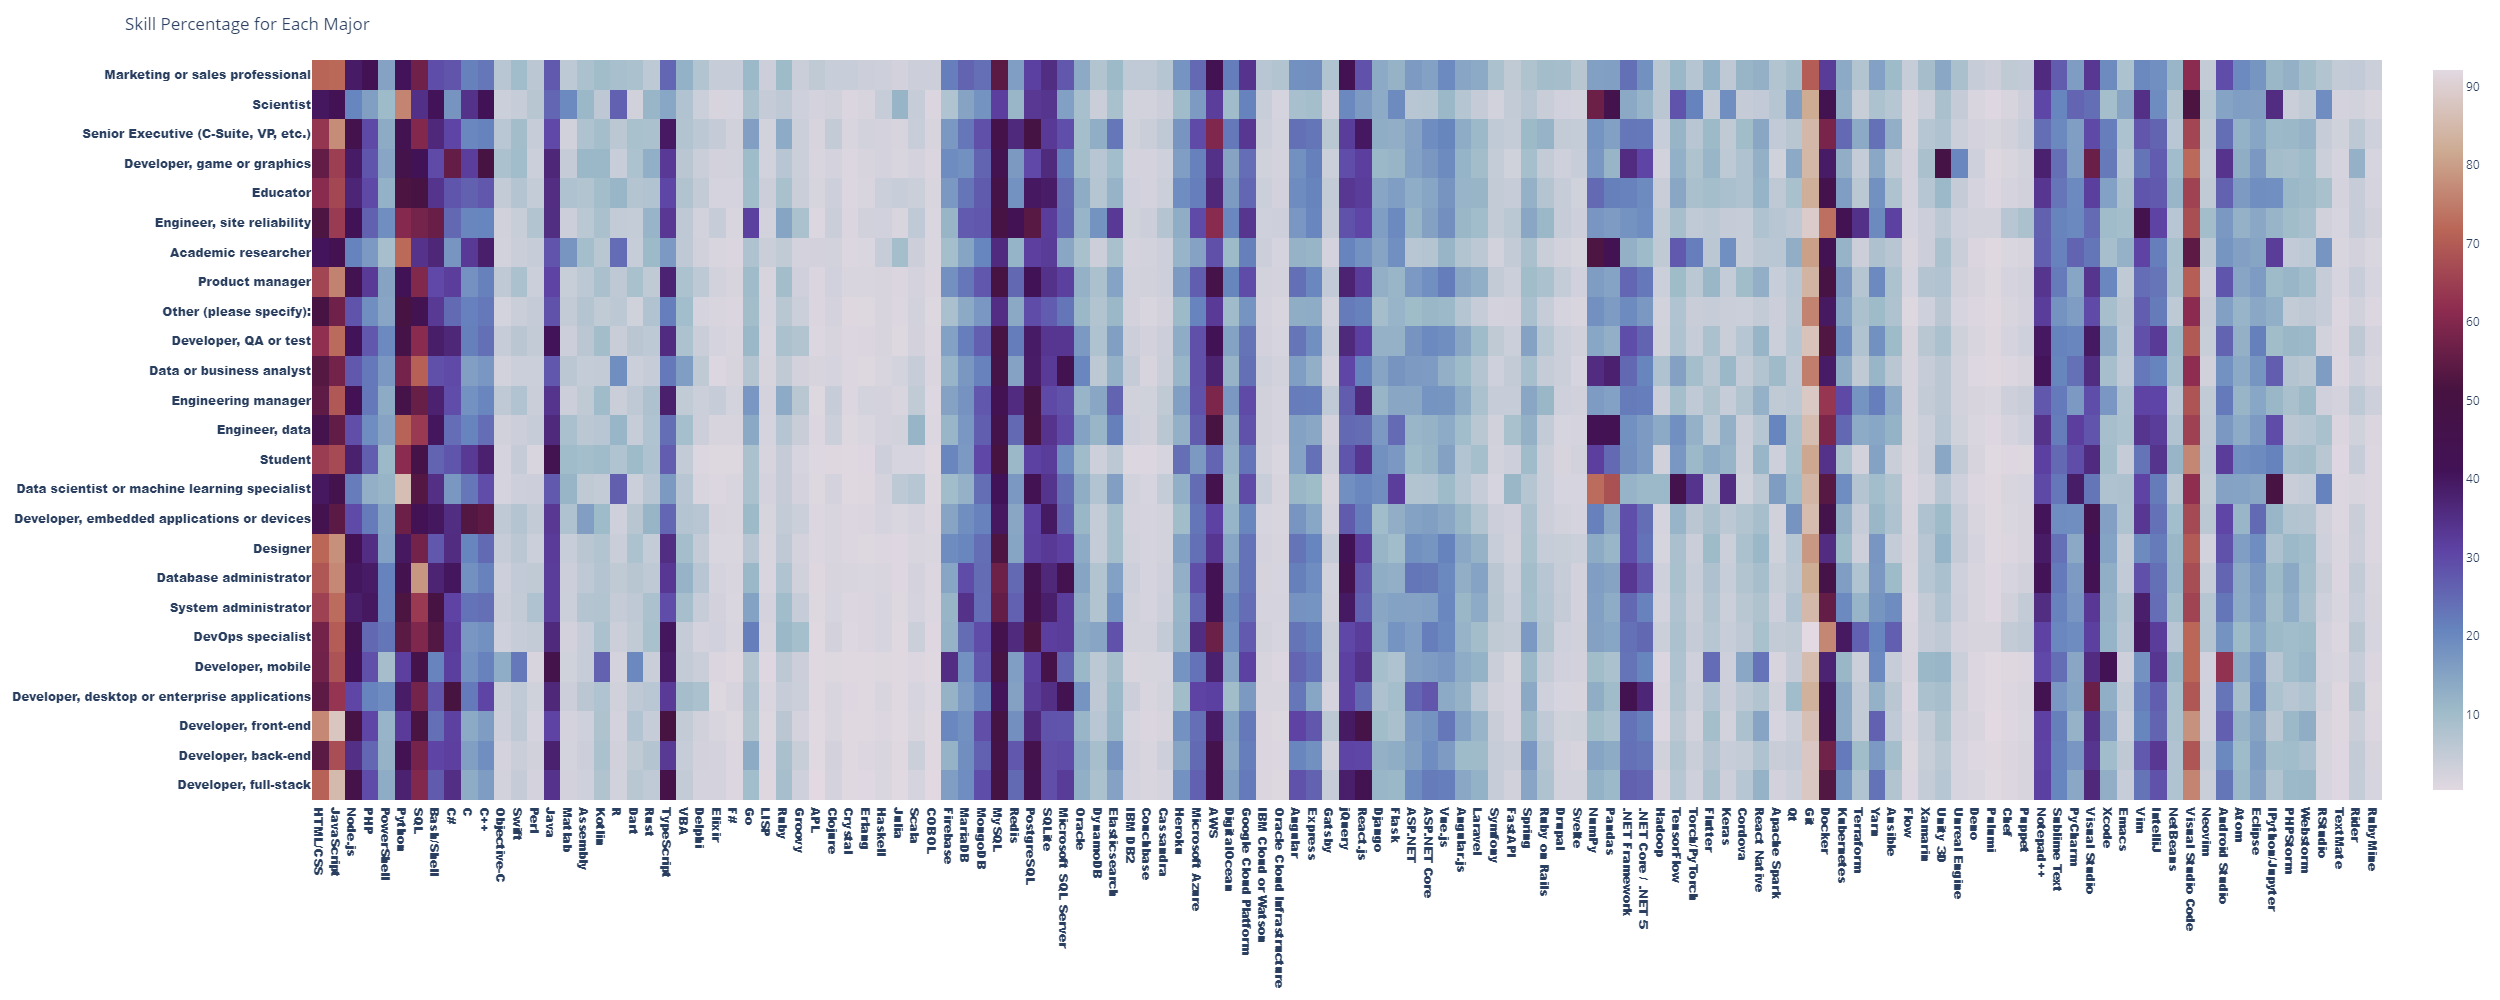

In [139]:

fig = go.Figure(data = px.imshow(job_to_skill_percentage,x=job_to_skill_percentage.columns ,
                                 y = job_to_skill_percentage.index,color_continuous_scale='twilight',aspect='auto'),
                layout_title_text = "Skill Percentage for Each Major"
               )
fig.update_layout(width = 2500 , height = 1000)
fig.update_xaxes(tickfont_family="Arial Black")
fig.update_yaxes(tickfont_family="Arial Black")
fig.show(renderer='png')
#fig.show()

In [46]:
# here i will make my data following the normal distribution that's equal i will normalize my data

from sklearn.preprocessing import StandardScaler
std_data = StandardScaler().fit_transform(job_to_skill_percentage)
std_data = pd.DataFrame(std_data , columns=job_to_skill_percentage.columns,index = job_to_skill_percentage.index)


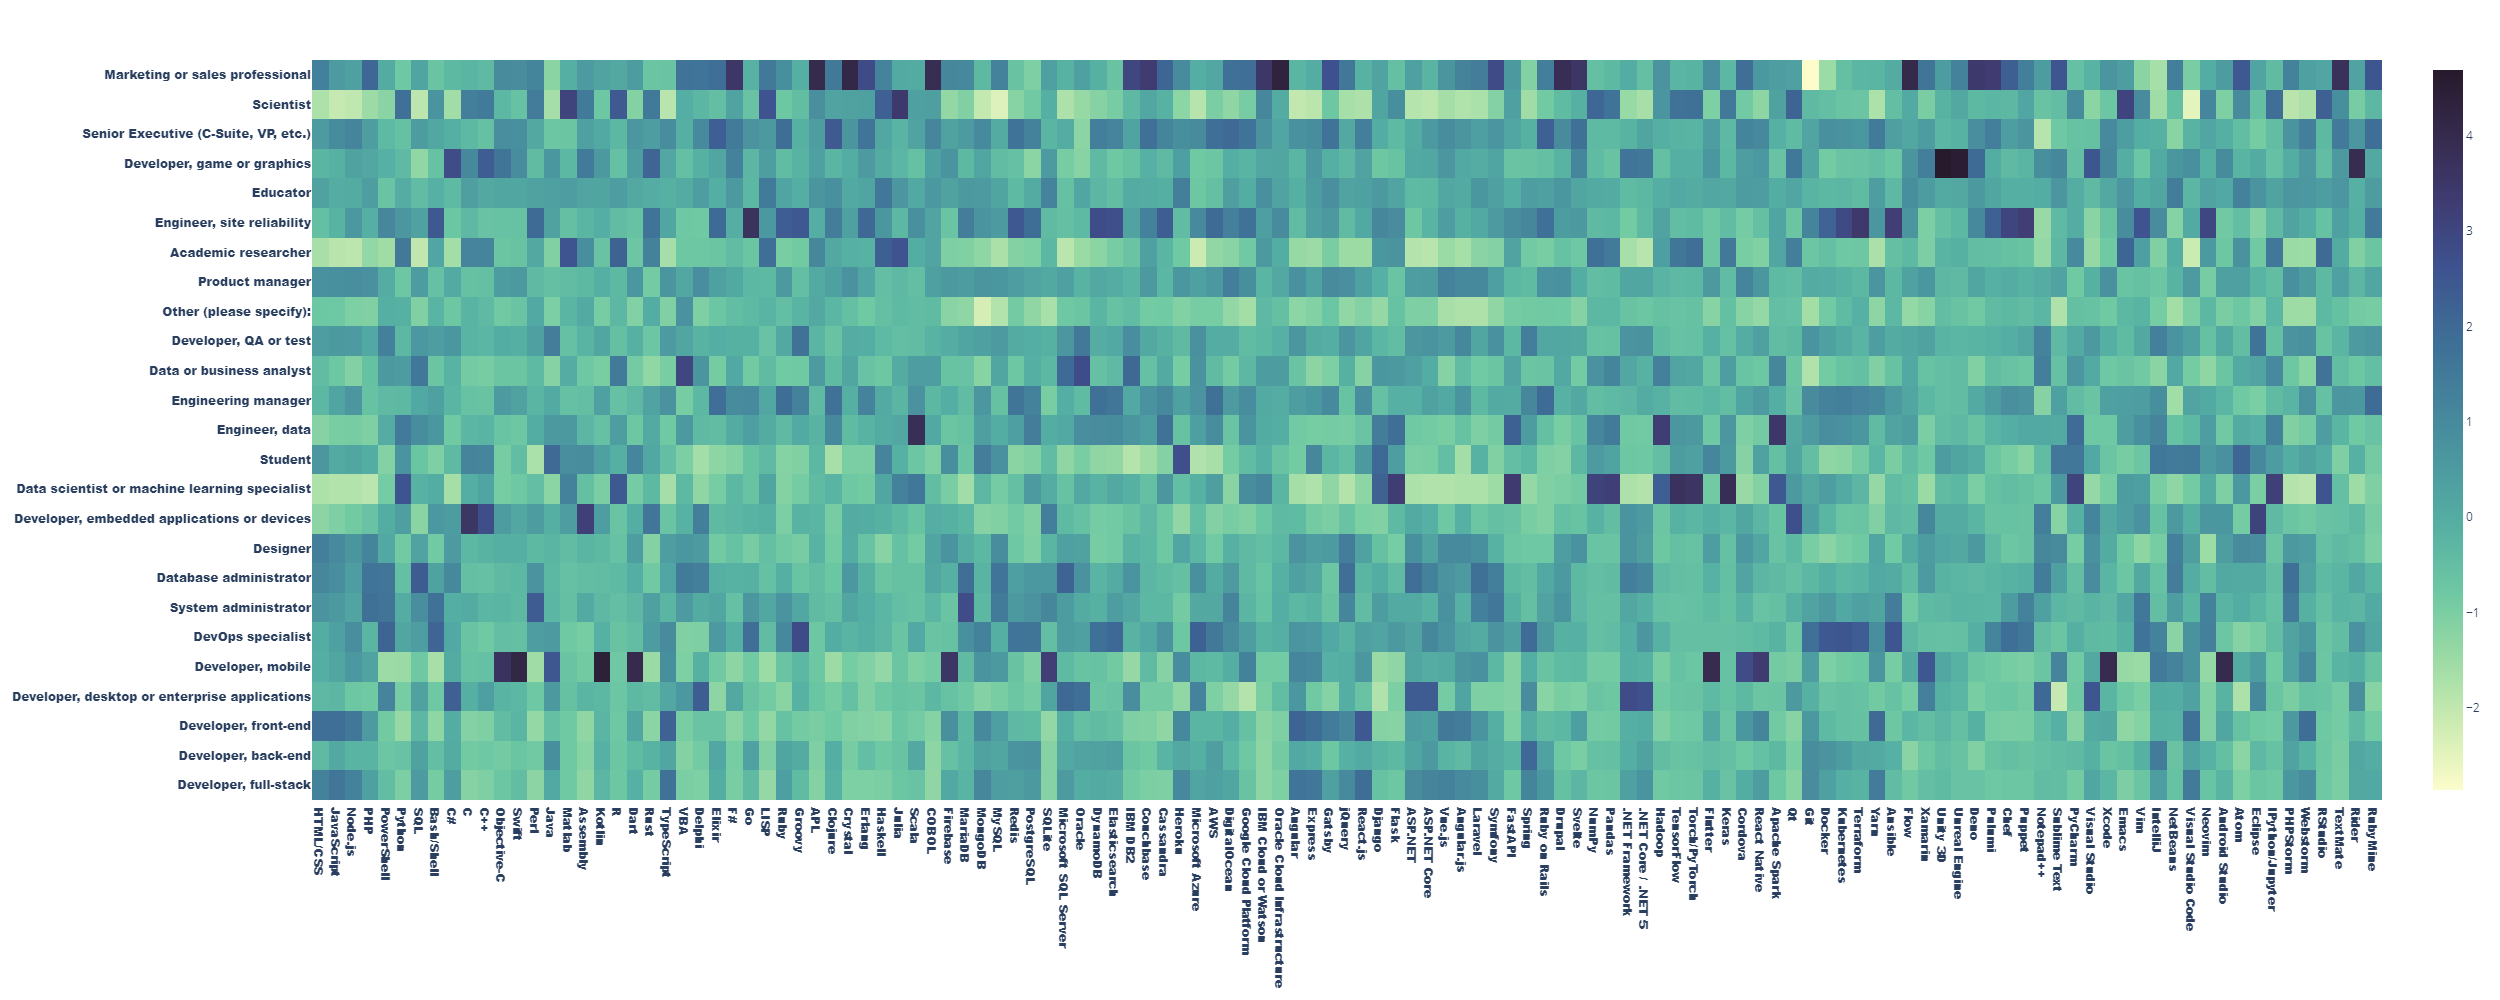

In [140]:
#But Now What is this ? why we could even need to normalize the data?
#What we did here is simply we look to each feature and say,okay i need to know for each skill i have, say we talk 
#about (C Language) what is the distance between each major and the mean ,but what is that mean ?
#simply if we look for (eg:Developer, embedded applications or devices major) u will notice that it is far away
#by 3.56 standard diviations,that means from the whole majors used (C language),
#that specific major it's highly Using (C language) if we compare it with other majors,
#even it's just using by 52% ,but when we compare it with other's majors it's highly used 
#look for the next cell and u will notice what i'm talking about

fig = go.Figure(data = px.imshow(std_data,x=job_to_skill_percentage.columns 
                                 , y = job_to_skill_percentage.index,color_continuous_scale='deep',aspect='auto'))
fig.update_layout(width = 2500 , height = 1000)
fig.update_xaxes(tickfont_family="Arial Black")
fig.update_yaxes(tickfont_family="Arial Black")
fig.show(renderer='png')
#fig.show()

In [68]:
#if we look to just Developer, embedded applications or devices we will notice that it is just 52% ,Nothing useful 
#at all ,but if we look to the whole majors we will notice that it's highly used in this specific major if we 
#compare it with others
for i in std_data.index:
    print(i,"|",job_to_skill_percentage.loc[i]['C'])

Marketing or sales professional | 21.316614420062695
Scientist | 34.59057071960297
Senior Executive (C-Suite, VP, etc.) | 20.256776034236804
Developer, game or graphics | 32.14962121212121
Educator | 26.382439848037148
Engineer, site reliability | 20.424836601307188
Academic researcher | 33.01138323559849
Product manager | 18.445022771633052
Other (please specify): | 21.354019746121295
Developer, QA or test | 21.48989199667682
Data or business analyst | 15.849156118143458
Engineering manager | 18.37270341207349
Engineer, data | 20.953065134099617
Student | 33.12634344399331
Data scientist or machine learning specialist | 22.93470629534285
Developer, embedded applications or devices | 52.892561983471076
Designer | 20.819778789850357
Database administrator | 18.76215738284704
System administrator | 23.638756374403684
DevOps specialist | 17.611221309152736
Developer, mobile | 18.357142857142858
Developer, desktop or enterprise applications | 22.508155128669806
Developer, front-end | 13.88

In [113]:
#Pick Random major to Visualize
major = np.random.choice(std_data.index)
major ='Developer, game or graphics' # i did it because i give u one example that explain what is happens down

'Developer, game or graphics'

In [119]:
Freq_and_NormalDist_comparison = pd.concat([job_to_skill_percentage.loc[major],std_data.loc[major]],axis=1)
Freq_and_NormalDist_comparison.columns = ['Percentage' , 'Z-Score']
Freq_and_NormalDist_comparison = Freq_and_NormalDist_comparison.sort_values('Percentage')
Freq_and_NormalDist_comparison

,Percentage,Z-Score
Pulumi,1.136364,-0.012435
Crystal,1.373106,-0.003102
COBOL,1.609848,0.340340
Julia,1.799242,-0.248390
Chef,1.846591,-0.359772
...,...,...
C#,55.445076,2.806263
Visual Studio,56.250000,2.528707
JavaScript,64.914773,-0.110419
Visual Studio Code,72.206439,0.829680


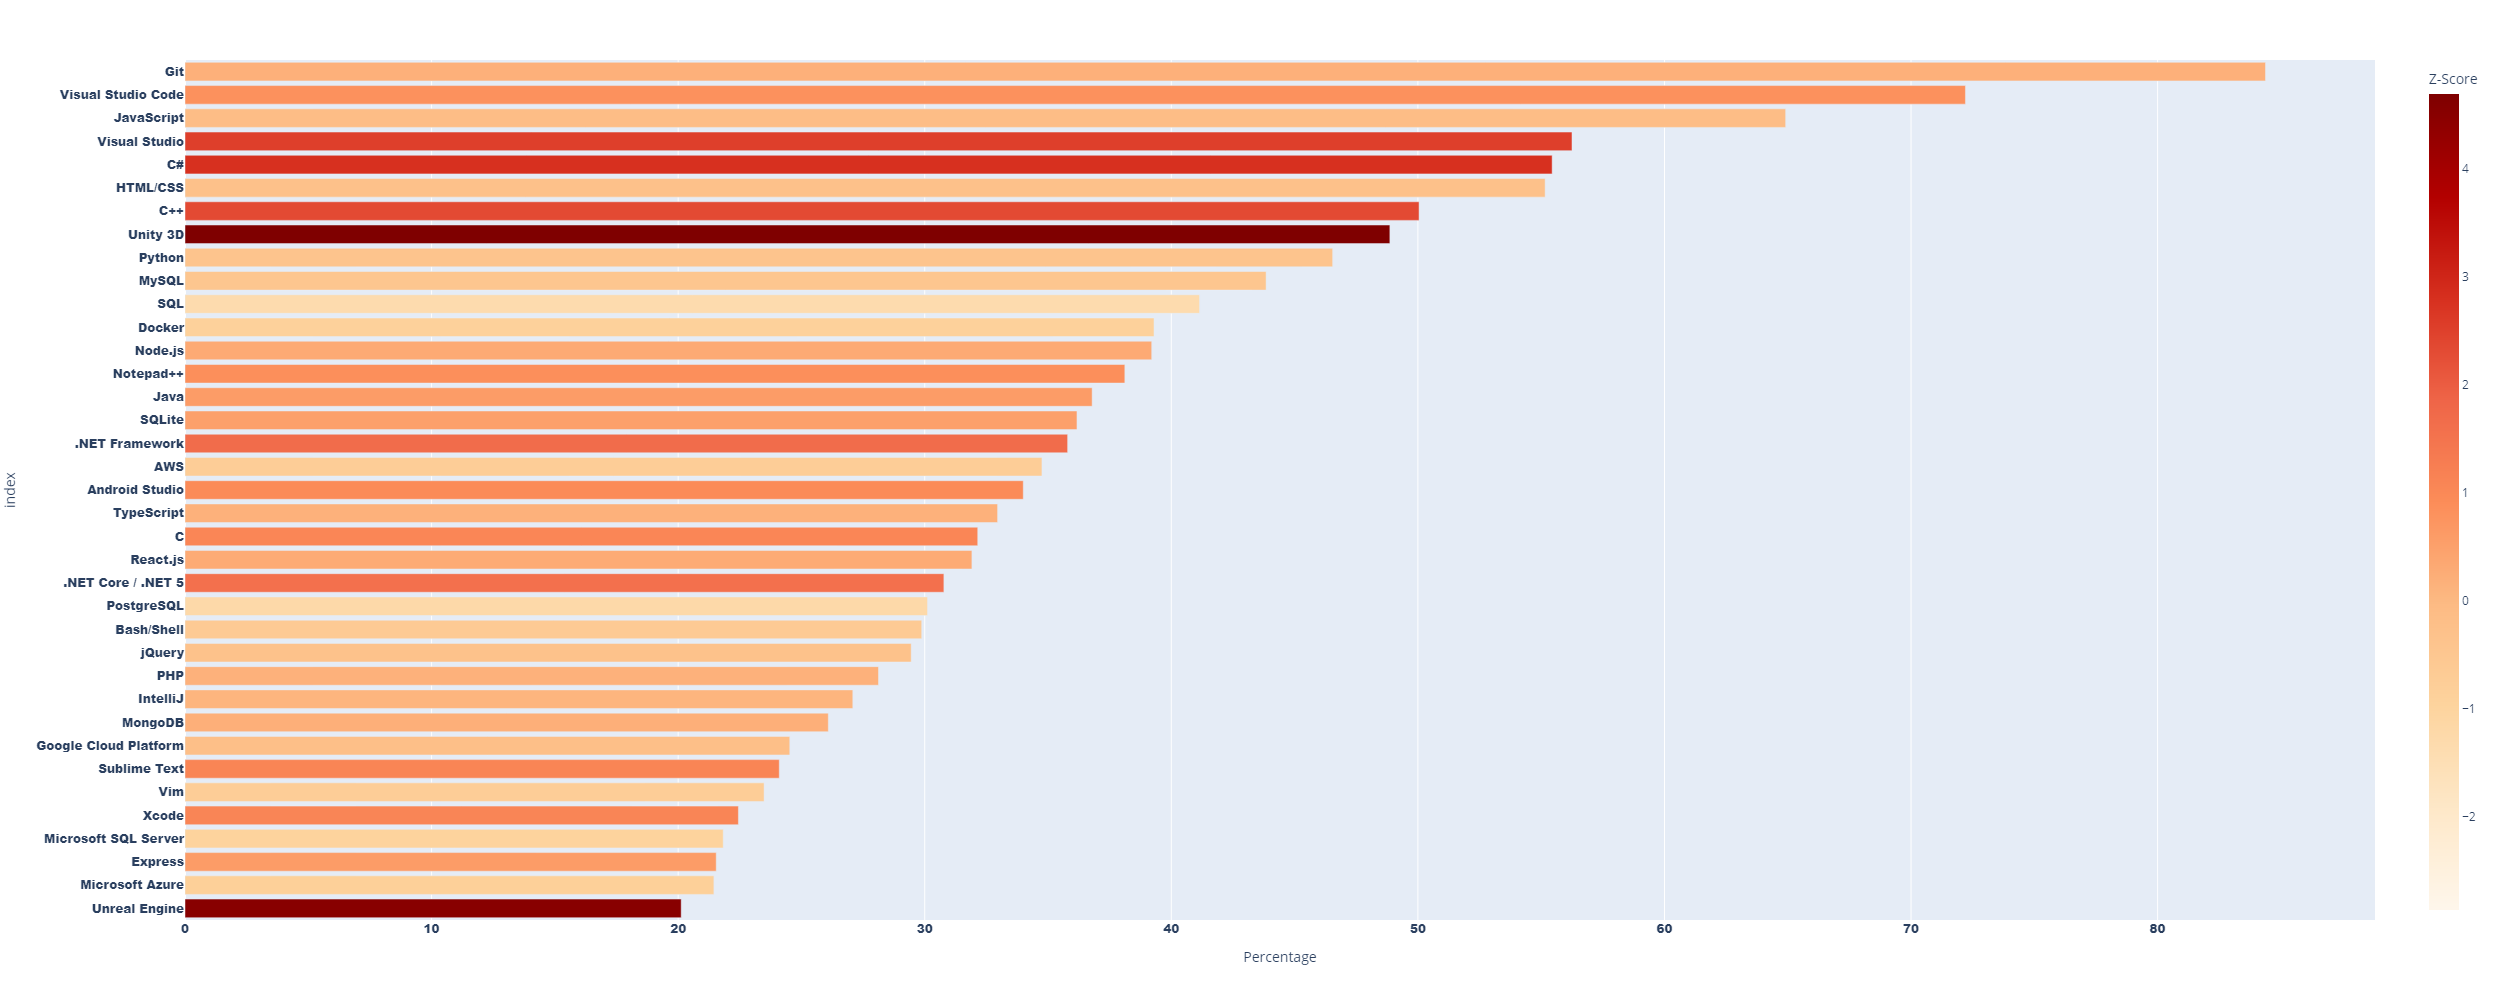

In [141]:
#if u look to this plot u will notice something,if u looked to (Unreal_Engine Or Unity 3D) when u compare it with
#(eg:Git),in Unreal Engine and Unity 3d it's less than used when u compare it with git (Less than 50%)
#but in the other hand (Git more than 80%) ,but the difference here is when u look to (Unreal_Eng And Unity 3D)
#in This specific Major it is highly used when u compare it with the other majors

threshold = 20 #Get the skill has percentage more than this threshold

Freq_and_NormalDist_comparison = Freq_and_NormalDist_comparison[Freq_and_NormalDist_comparison['Percentage']>threshold] 

fig = px.bar(Freq_and_NormalDist_comparison,
            y = Freq_and_NormalDist_comparison.index,
            x = Freq_and_NormalDist_comparison['Percentage'],
            color = Freq_and_NormalDist_comparison['Z-Score'],
            color_continuous_scale='orrd',
            range_color=[std_data.values.min(),std_data.values.max()]
            )
fig.update_layout(width = 2500 , height = 1000)
fig.update_xaxes(tickfont_family="Arial Black")
fig.update_yaxes(tickfont_family="Arial Black")
fig.show(renderer='png')
#fig.show()

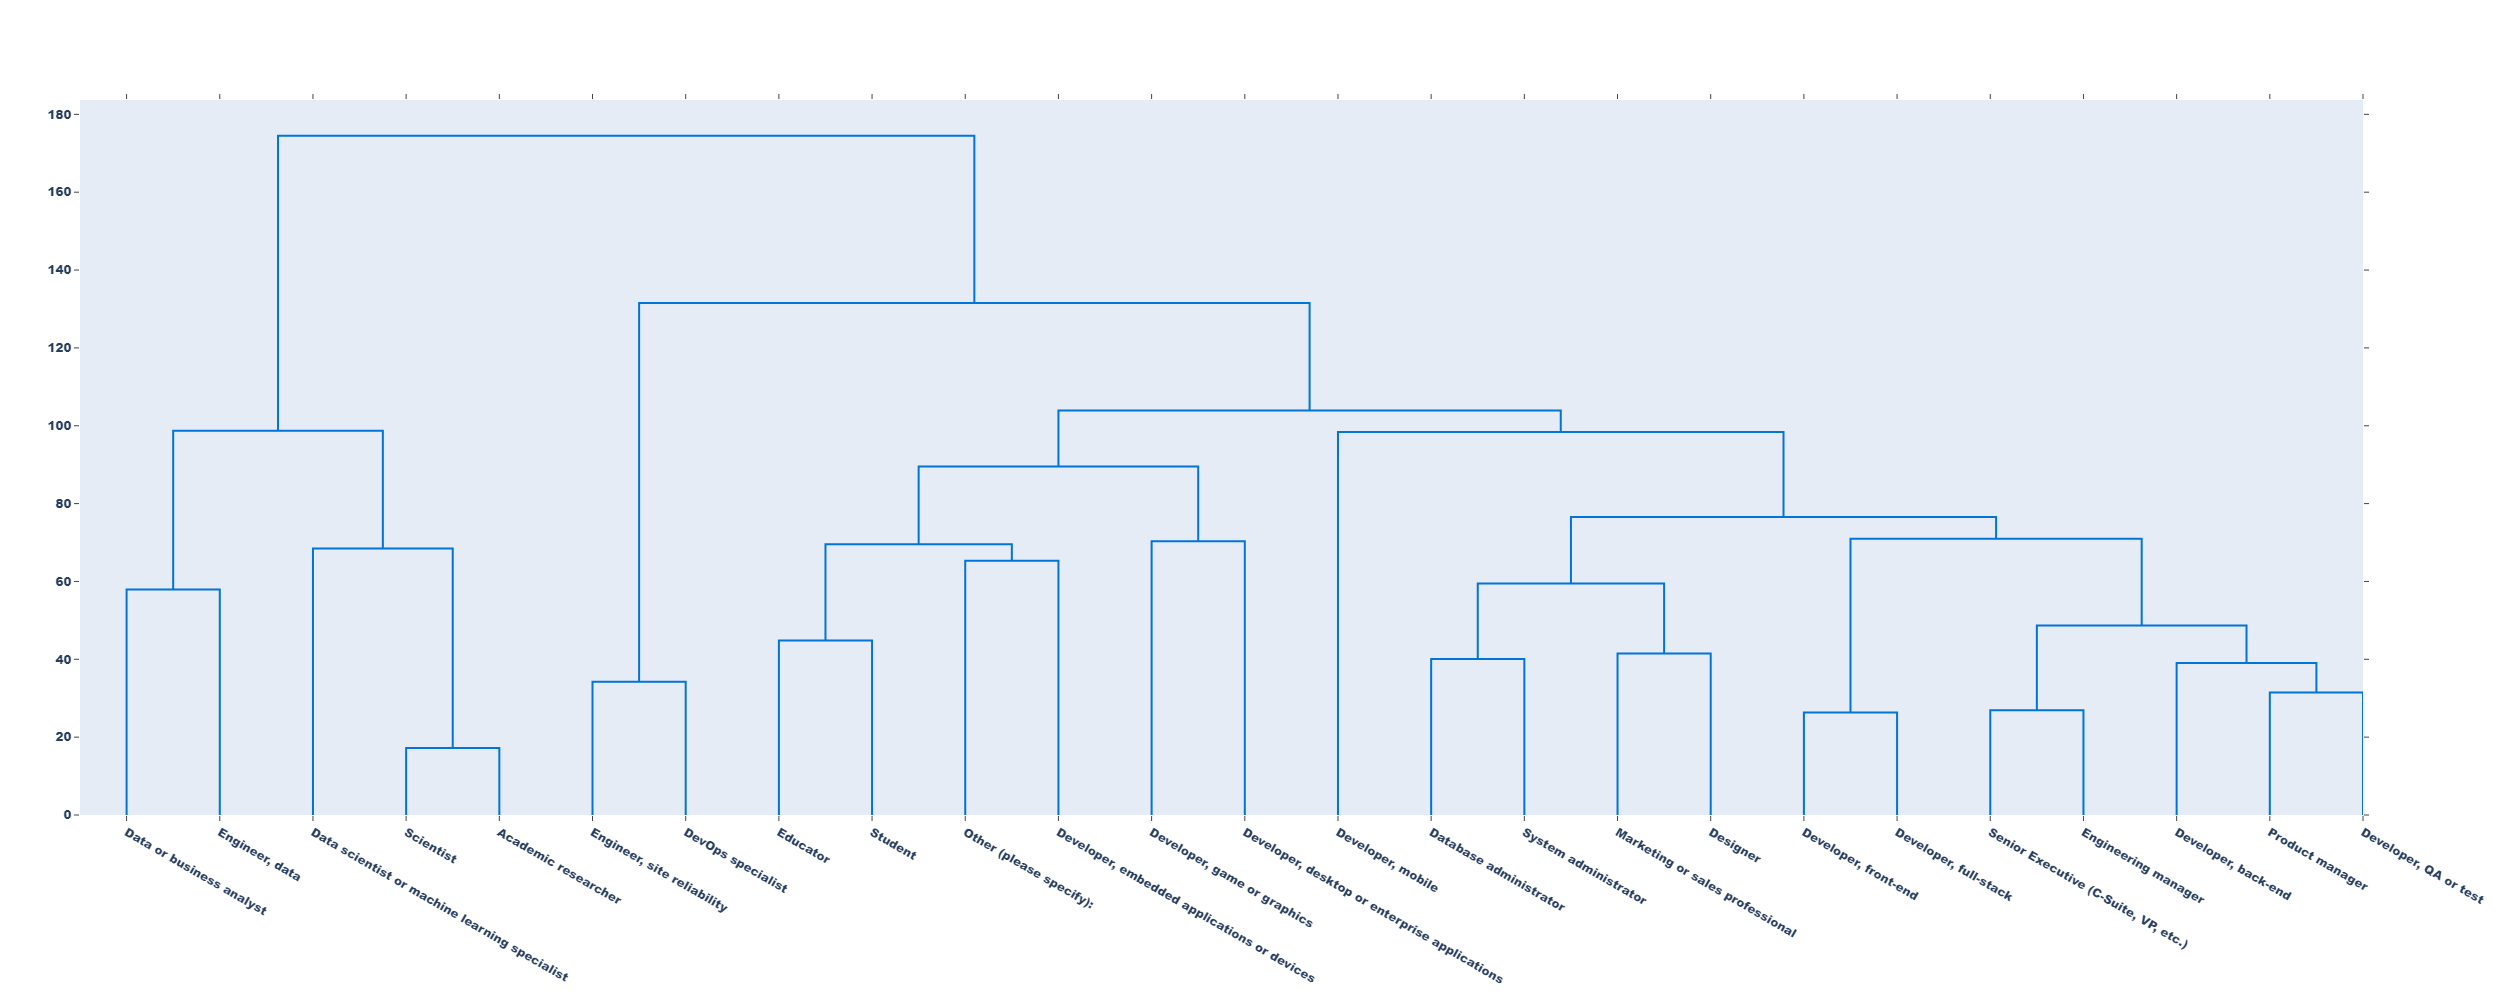

In [142]:
#here i'm trying to know what is the closest majors to each other if we ignore the rest of features and focus on
#just the skills

import plotly.figure_factory as ff

fig = ff.create_dendrogram(job_to_skill_percentage
                           , color_threshold=1.5
                           ,labels=job_to_skill_percentage.index)
fig.update_layout(width = 2500 , height = 1000)
fig.update_xaxes(tickfont_family="Arial Black")
fig.update_yaxes(tickfont_family="Arial Black")
fig.show(renderer='png')
#fig.show()